In [1]:
from datasets import load_dataset, Dataset
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.core.module import LightningModule
from lightning.pytorch.trainer import Trainer
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.loggers.csv_logs import CSVLogger
import pandas as pd
import pytorch_lightning as pl
import torch
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torch import nn
from torch.optim import AdamW
from transformers import AutoModelForMaskedLM, AutoModelForSequenceClassification, AutoTokenizer, get_cosine_schedule_with_warmup

In [31]:
RANDOM_SEED = 42
BATCH_SIZE = 4
GRADIENT_ACC= 8
OBJECTIVE = "mlm"
VARIANT = "large"
TOKENIZER_NAME = f"neuralmind/bert-{VARIANT}-portuguese-cased"
MODEL_NAME =  f"neuralmind/bert-{VARIANT}-portuguese-cased"
EXPERIMENT_NAME = f"enem_essay_score_{OBJECTIVE}_bert_{VARIANT}_finetuning"

pl.seed_everything(RANDOM_SEED)
torch.set_float32_matmul_precision('medium')

Seed set to 42


In [32]:
dataset = load_dataset("kamel-usp/aes_enem_dataset", "sourceB", cache_dir="/tmp/aes_enem")

In [33]:
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME, use_fast=True)
tokenized_dataset = tokenizer(dataset["full"]["essay_text"], return_tensors='pt', truncation=True, padding='max_length', max_length=512) 
tokenized_dataset = Dataset.from_dict(tokenized_dataset)

In [34]:
split_data = tokenized_dataset.train_test_split(test_size=0.1)
train_dataset = split_data["train"].with_format("torch")
val_dataset = split_data["test"].with_format("torch")
dataset_train = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
dataset_val = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
len(dataset_val)*BATCH_SIZE, len(dataset_val)*BATCH_SIZE

(324, 324)

In [35]:
model = AutoModelForMaskedLM.from_pretrained(
            MODEL_NAME, 
            cache_dir="/tmp/", 
        )

config.json:   0%|          | 0.00/865 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

In [36]:
def calculate_pseudo_perplexity(model, dataloader):
    model = model.to('cuda')
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_count = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Computing pseudo-perplexity"):
            # Move batch tensors to the same device as the model
            input_ids = batch['input_ids'].to('cuda')
            token_type_ids = batch['token_type_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            
            # Create masks - mask 15% of tokens for MLM
            probability_matrix = torch.full(input_ids.shape, 0.15).to('cuda')
            masked_indices = torch.bernoulli(probability_matrix).bool()
            original_input_ids = input_ids.clone()
            input_ids[masked_indices] = tokenizer.convert_tokens_to_ids('[MASK]')

            # Compute the MLM Loss
            outputs = model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=original_input_ids)
            loss = outputs.loss

            total_loss += loss.item() * input_ids.size(0)
            total_count += input_ids.size(0)

    # Average the loss over all tokens
    average_loss = total_loss / total_count

    # Compute the pseudo-perplexity
    perplexity = torch.exp(torch.tensor(average_loss))

    return perplexity.item()

In [37]:
mlm_perplexity = calculate_pseudo_perplexity(model, dataset_val)
print(f"Initial Perplexity on validation set: {mlm_perplexity:.2f}")

Computing pseudo-perplexity:   0%|          | 0/81 [00:00<?, ?it/s]

Initial Perplexity on validation set: 1.17


In [9]:
class LightningGradePredictor(LightningModule):
    def __init__(self, model: nn.Module, learning_rate=0.001, num_warmup_steps=None, num_training_steps=None):
        super(LightningGradePredictor, self).__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.num_warmup_steps = num_warmup_steps
        self.num_training_steps = num_training_steps
        self.save_hyperparameters(ignore=['model', 'loss_function'])
        self.training_step_loss = []
        self.validation_step_loss = []

    def forward(self, input_ids, attention_mask, token_type_ids, labels):
        return self.model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels)

    def training_step(self, batch, batch_idx):
        input_ids, attention_mask, token_type_ids = batch["input_ids"], batch["attention_mask"], batch["token_type_ids"]
        probability_matrix = torch.full(input_ids.shape, 0.15).to('cuda')
        masked_indices = torch.bernoulli(probability_matrix).bool()
        original_input_ids = input_ids.clone()
        input_ids[masked_indices] = tokenizer.convert_tokens_to_ids('[MASK]')

        # Compute the MLM Loss
        outputs = model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=original_input_ids)
        loss = outputs.loss
        self.log('train_loss', loss)
        self.training_step_loss.append(loss)
        optimizer = self.optimizers()
        if isinstance(optimizer, list):
            optimizer = optimizer[0]
        lr_current = optimizer.optimizer.param_groups[0]['lr']
        self.log('current_lr', lr_current)
        return loss
    
    def validation_step(self, batch, batch_idx):
        input_ids, attention_mask, token_type_ids = batch["input_ids"], batch["attention_mask"], batch["token_type_ids"]
        probability_matrix = torch.full(input_ids.shape, 0.15).to('cuda')
        masked_indices = torch.bernoulli(probability_matrix).bool()
        original_input_ids = input_ids.clone()
        input_ids[masked_indices] = tokenizer.convert_tokens_to_ids('[MASK]')

        # Compute the MLM Loss
        outputs = model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=original_input_ids)
        loss = outputs.loss
        self.log('val_loss', loss)
        self.validation_step_loss.append(loss)
        return loss

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.learning_rate, weight_decay=0.01)

        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.num_warmup_steps,
            num_training_steps=self.num_training_steps
        )

        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]

In [10]:
from IPython.display import display
from lightning.pytorch.callbacks import Callback

class EpochEndCallback(Callback):
    def __init__(self):
        self.metrics_df = pd.DataFrame(
            columns=['Epoch', 'Train Loss', 'Validation Loss', 'Train Perplexity', 'Validation Perplexity'])
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def on_train_epoch_end(self, trainer, pl_module):
        current_epoch = trainer.current_epoch
        # Metrics for training data
        train_dataloader = trainer.train_dataloader
        val_dataloader = trainer.val_dataloaders
        
        epoch_train_loss_mean = torch.stack(pl_module.training_step_loss).mean()
        epoch_val_loss_mean = torch.stack(pl_module.validation_step_loss).mean()
        pl_module.training_step_loss.clear()
        pl_module.validation_step_loss.clear()
        model.eval()
        train_perplexity = calculate_pseudo_perplexity(model, train_dataloader)
        val_perplexity = calculate_pseudo_perplexity(model, val_dataloader)
        pl_module.log('val_perplexity', val_perplexity)

        new_row = {'Epoch': current_epoch, 
                    'Train Loss': epoch_train_loss_mean.cpu().detach().numpy(),
                    'Validation Loss': epoch_val_loss_mean.cpu().detach().numpy(),
                    'Train Perplexity': train_perplexity,
                    'Validation Perplexity': val_perplexity
                    }
        new_row = pd.Series(new_row).to_frame().T
        self.metrics_df = pd.concat([self.metrics_df, new_row])
        display(self.metrics_df)


In [11]:
early_stop_callback = EarlyStopping(monitor="val_perplexity", patience=3, verbose=True, mode="min")
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor="val_perplexity", mode="min")

In [12]:
NUM_EPOCHS = 100
num_training_steps = NUM_EPOCHS * len(dataset_train)
warmup_steps = int(num_training_steps * 0.1)
logger = CSVLogger("model_logs", name="enem_self_supervised")
steps_per_epoch = num_training_steps//NUM_EPOCHS
model.train()
trainer = Trainer(
    max_epochs=NUM_EPOCHS, 
    log_every_n_steps=steps_per_epoch, 
    logger=logger, 
    callbacks=[EpochEndCallback(), early_stop_callback, checkpoint_callback],
    precision='16-mixed',
    accumulate_grad_batches=GRADIENT_ACC
)
ligthning_model = LightningGradePredictor(model, 
                    num_training_steps=num_training_steps,
                    num_warmup_steps=warmup_steps
                    )

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(model=ligthning_model, 
                          train_dataloaders=dataset_train, 
                          val_dataloaders=dataset_val, num_training=100)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/andrebarbosa/miniconda3/envs/aes_enem/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/home/andrebarbosa/miniconda3/envs/aes_enem/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/home/andrebarbosa/miniconda3/envs/aes_enem/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 3.311311214825911e-05
Restoring states from the checkpoint path at /home/andrebarbosa/aes_enem/.lr_find_9c075331-7b63-497c-8ced-4a2531ed7931.ckpt
Restored all states from the checkpoint at /home/andrebarbosa/aes_enem/.lr_find_9c075331-7b63-497c-8ced-4a2531ed7931.ckpt


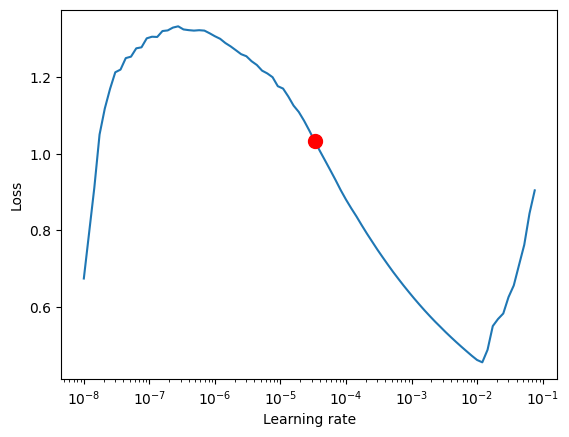

In [14]:
target_lr = lr_finder.suggestion()
fig = lr_finder.plot(suggest=False)
lrs = lr_finder.results["lr"]
losses = lr_finder.results["loss"]
nearest_lr = min(lrs, key=lambda x: abs(x - target_lr))
index = lrs.index(nearest_lr)
fig.axes[0].plot(lrs[index], losses[index], markersize=10, marker="o", color="red")
fig.show()

In [15]:
print(f"LR chosen to be used: {lrs[index]}")
new_lr = lrs[index]

LR chosen to be used: 3.311311214825911e-05


In [16]:
ligthning_model = LightningGradePredictor(model, 
                    num_training_steps=num_training_steps,
                    num_warmup_steps=warmup_steps,
                    learning_rate = new_lr
                    )
                    
trainer.fit(model=ligthning_model, train_dataloaders=dataset_train, val_dataloaders=dataset_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params
------------------------------------------
0 | model | BertForMaskedLM | 108 M 
------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
435.818   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/725 [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/81 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train Perplexity,Validation Perplexity
0,0,9.712491,7.7386584,1945.368896,2410.320801


Metric val_perplexity improved. New best score: 2410.321


Validation: |          | 0/? [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/725 [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/81 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train Perplexity,Validation Perplexity
0,0,9.712491,7.7386584,1945.368896,2410.320801
0,1,5.2702804,3.4737139,25.196524,29.98979


Metric val_perplexity improved by 2380.331 >= min_delta = 0.0. New best score: 29.990


Validation: |          | 0/? [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/725 [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/81 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train Perplexity,Validation Perplexity
0,0,9.712491,7.7386584,1945.368896,2410.320801
0,1,5.2702804,3.4737139,25.196524,29.98979
0,2,1.9089866,1.3087386,3.334974,3.636567


Metric val_perplexity improved by 26.353 >= min_delta = 0.0. New best score: 3.637


Validation: |          | 0/? [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/725 [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/81 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train Perplexity,Validation Perplexity
0,0,9.712491,7.7386584,1945.368896,2410.320801
0,1,5.2702804,3.4737139,25.196524,29.98979
0,2,1.9089866,1.3087386,3.334974,3.636567
0,3,0.9772852,0.86348265,2.207242,2.317756


Metric val_perplexity improved by 1.319 >= min_delta = 0.0. New best score: 2.318


Validation: |          | 0/? [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/725 [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/81 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train Perplexity,Validation Perplexity
0,0,9.712491,7.7386584,1945.368896,2410.320801
0,1,5.2702804,3.4737139,25.196524,29.98979
0,2,1.9089866,1.3087386,3.334974,3.636567
0,3,0.9772852,0.86348265,2.207242,2.317756
0,4,0.6957231,0.59553385,1.866667,2.007807


Metric val_perplexity improved by 0.310 >= min_delta = 0.0. New best score: 2.008


Validation: |          | 0/? [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/725 [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/81 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train Perplexity,Validation Perplexity
0,0,9.712491,7.7386584,1945.368896,2410.320801
0,1,5.2702804,3.4737139,25.196524,29.98979
0,2,1.9089866,1.3087386,3.334974,3.636567
0,3,0.9772852,0.86348265,2.207242,2.317756
0,4,0.6957231,0.59553385,1.866667,2.007807
0,5,0.5585126,0.5009365,1.674152,1.633351


Metric val_perplexity improved by 0.374 >= min_delta = 0.0. New best score: 1.633


Validation: |          | 0/? [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/725 [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/81 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train Perplexity,Validation Perplexity
0,0,9.712491,7.7386584,1945.368896,2410.320801
0,1,5.2702804,3.4737139,25.196524,29.98979
0,2,1.9089866,1.3087386,3.334974,3.636567
0,3,0.9772852,0.86348265,2.207242,2.317756
0,4,0.6957231,0.59553385,1.866667,2.007807
0,5,0.5585126,0.5009365,1.674152,1.633351
0,6,0.47072127,0.43331712,1.539256,1.560963


Metric val_perplexity improved by 0.072 >= min_delta = 0.0. New best score: 1.561


Validation: |          | 0/? [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/725 [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/81 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train Perplexity,Validation Perplexity
0,0,9.712491,7.7386584,1945.368896,2410.320801
0,1,5.2702804,3.4737139,25.196524,29.98979
0,2,1.9089866,1.3087386,3.334974,3.636567
0,3,0.9772852,0.86348265,2.207242,2.317756
0,4,0.6957231,0.59553385,1.866667,2.007807
0,5,0.5585126,0.5009365,1.674152,1.633351
0,6,0.47072127,0.43331712,1.539256,1.560963
0,7,0.401275,0.38442972,1.456342,1.505892


Metric val_perplexity improved by 0.055 >= min_delta = 0.0. New best score: 1.506


Validation: |          | 0/? [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/725 [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/81 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train Perplexity,Validation Perplexity
0,0,9.712491,7.7386584,1945.368896,2410.320801
0,1,5.2702804,3.4737139,25.196524,29.98979
0,2,1.9089866,1.3087386,3.334974,3.636567
0,3,0.9772852,0.86348265,2.207242,2.317756
0,4,0.6957231,0.59553385,1.866667,2.007807
0,5,0.5585126,0.5009365,1.674152,1.633351
0,6,0.47072127,0.43331712,1.539256,1.560963
0,7,0.401275,0.38442972,1.456342,1.505892
0,8,0.3508585,0.33663556,1.392079,1.394289


Metric val_perplexity improved by 0.112 >= min_delta = 0.0. New best score: 1.394


Validation: |          | 0/? [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/725 [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/81 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train Perplexity,Validation Perplexity
0,0,9.712491,7.7386584,1945.368896,2410.320801
0,1,5.2702804,3.4737139,25.196524,29.98979
0,2,1.9089866,1.3087386,3.334974,3.636567
0,3,0.9772852,0.86348265,2.207242,2.317756
0,4,0.6957231,0.59553385,1.866667,2.007807
0,5,0.5585126,0.5009365,1.674152,1.633351
0,6,0.47072127,0.43331712,1.539256,1.560963
0,7,0.401275,0.38442972,1.456342,1.505892
0,8,0.3508585,0.33663556,1.392079,1.394289
0,9,0.31537148,0.2953225,1.336661,1.350569


Metric val_perplexity improved by 0.044 >= min_delta = 0.0. New best score: 1.351


Validation: |          | 0/? [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/725 [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/81 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train Perplexity,Validation Perplexity
0,0,9.712491,7.7386584,1945.368896,2410.320801
0,1,5.2702804,3.4737139,25.196524,29.98979
0,2,1.9089866,1.3087386,3.334974,3.636567
0,3,0.9772852,0.86348265,2.207242,2.317756
0,4,0.6957231,0.59553385,1.866667,2.007807
0,5,0.5585126,0.5009365,1.674152,1.633351
0,6,0.47072127,0.43331712,1.539256,1.560963
0,7,0.401275,0.38442972,1.456342,1.505892
0,8,0.3508585,0.33663556,1.392079,1.394289
0,9,0.31537148,0.2953225,1.336661,1.350569


Metric val_perplexity improved by 0.035 >= min_delta = 0.0. New best score: 1.315


Validation: |          | 0/? [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/725 [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/81 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train Perplexity,Validation Perplexity
0,0,9.712491,7.7386584,1945.368896,2410.320801
0,1,5.2702804,3.4737139,25.196524,29.98979
0,2,1.9089866,1.3087386,3.334974,3.636567
0,3,0.9772852,0.86348265,2.207242,2.317756
0,4,0.6957231,0.59553385,1.866667,2.007807
0,5,0.5585126,0.5009365,1.674152,1.633351
0,6,0.47072127,0.43331712,1.539256,1.560963
0,7,0.401275,0.38442972,1.456342,1.505892
0,8,0.3508585,0.33663556,1.392079,1.394289
0,9,0.31537148,0.2953225,1.336661,1.350569


Metric val_perplexity improved by 0.026 >= min_delta = 0.0. New best score: 1.290


Validation: |          | 0/? [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/725 [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/81 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train Perplexity,Validation Perplexity
0,0,9.712491,7.7386584,1945.368896,2410.320801
0,1,5.2702804,3.4737139,25.196524,29.98979
0,2,1.9089866,1.3087386,3.334974,3.636567
0,3,0.9772852,0.86348265,2.207242,2.317756
0,4,0.6957231,0.59553385,1.866667,2.007807
0,5,0.5585126,0.5009365,1.674152,1.633351
0,6,0.47072127,0.43331712,1.539256,1.560963
0,7,0.401275,0.38442972,1.456342,1.505892
0,8,0.3508585,0.33663556,1.392079,1.394289
0,9,0.31537148,0.2953225,1.336661,1.350569


Metric val_perplexity improved by 0.020 >= min_delta = 0.0. New best score: 1.269


Validation: |          | 0/? [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/725 [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/81 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train Perplexity,Validation Perplexity
0,0,9.712491,7.7386584,1945.368896,2410.320801
0,1,5.2702804,3.4737139,25.196524,29.98979
0,2,1.9089866,1.3087386,3.334974,3.636567
0,3,0.9772852,0.86348265,2.207242,2.317756
0,4,0.6957231,0.59553385,1.866667,2.007807
0,5,0.5585126,0.5009365,1.674152,1.633351
0,6,0.47072127,0.43331712,1.539256,1.560963
0,7,0.401275,0.38442972,1.456342,1.505892
0,8,0.3508585,0.33663556,1.392079,1.394289
0,9,0.31537148,0.2953225,1.336661,1.350569


Metric val_perplexity improved by 0.014 >= min_delta = 0.0. New best score: 1.255


Validation: |          | 0/? [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/725 [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/81 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train Perplexity,Validation Perplexity
0,0,9.712491,7.7386584,1945.368896,2410.320801
0,1,5.2702804,3.4737139,25.196524,29.98979
0,2,1.9089866,1.3087386,3.334974,3.636567
0,3,0.9772852,0.86348265,2.207242,2.317756
0,4,0.6957231,0.59553385,1.866667,2.007807
0,5,0.5585126,0.5009365,1.674152,1.633351
0,6,0.47072127,0.43331712,1.539256,1.560963
0,7,0.401275,0.38442972,1.456342,1.505892
0,8,0.3508585,0.33663556,1.392079,1.394289
0,9,0.31537148,0.2953225,1.336661,1.350569


Metric val_perplexity improved by 0.015 >= min_delta = 0.0. New best score: 1.240


Validation: |          | 0/? [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/725 [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/81 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train Perplexity,Validation Perplexity
0,0,9.712491,7.7386584,1945.368896,2410.320801
0,1,5.2702804,3.4737139,25.196524,29.98979
0,2,1.9089866,1.3087386,3.334974,3.636567
0,3,0.9772852,0.86348265,2.207242,2.317756
0,4,0.6957231,0.59553385,1.866667,2.007807
0,5,0.5585126,0.5009365,1.674152,1.633351
0,6,0.47072127,0.43331712,1.539256,1.560963
0,7,0.401275,0.38442972,1.456342,1.505892
0,8,0.3508585,0.33663556,1.392079,1.394289
0,9,0.31537148,0.2953225,1.336661,1.350569


Metric val_perplexity improved by 0.009 >= min_delta = 0.0. New best score: 1.231


Validation: |          | 0/? [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/725 [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/81 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train Perplexity,Validation Perplexity
0,0,9.712491,7.7386584,1945.368896,2410.320801
0,1,5.2702804,3.4737139,25.196524,29.98979
0,2,1.9089866,1.3087386,3.334974,3.636567
0,3,0.9772852,0.86348265,2.207242,2.317756
0,4,0.6957231,0.59553385,1.866667,2.007807
0,5,0.5585126,0.5009365,1.674152,1.633351
0,6,0.47072127,0.43331712,1.539256,1.560963
0,7,0.401275,0.38442972,1.456342,1.505892
0,8,0.3508585,0.33663556,1.392079,1.394289
0,9,0.31537148,0.2953225,1.336661,1.350569


Metric val_perplexity improved by 0.009 >= min_delta = 0.0. New best score: 1.222


Validation: |          | 0/? [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/725 [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/81 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train Perplexity,Validation Perplexity
0,0,9.712491,7.7386584,1945.368896,2410.320801
0,1,5.2702804,3.4737139,25.196524,29.98979
0,2,1.9089866,1.3087386,3.334974,3.636567
0,3,0.9772852,0.86348265,2.207242,2.317756
0,4,0.6957231,0.59553385,1.866667,2.007807
0,5,0.5585126,0.5009365,1.674152,1.633351
0,6,0.47072127,0.43331712,1.539256,1.560963
0,7,0.401275,0.38442972,1.456342,1.505892
0,8,0.3508585,0.33663556,1.392079,1.394289
0,9,0.31537148,0.2953225,1.336661,1.350569


Validation: |          | 0/? [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/725 [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/81 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train Perplexity,Validation Perplexity
0,0,9.712491,7.7386584,1945.368896,2410.320801
0,1,5.2702804,3.4737139,25.196524,29.98979
0,2,1.9089866,1.3087386,3.334974,3.636567
0,3,0.9772852,0.86348265,2.207242,2.317756
0,4,0.6957231,0.59553385,1.866667,2.007807
0,5,0.5585126,0.5009365,1.674152,1.633351
0,6,0.47072127,0.43331712,1.539256,1.560963
0,7,0.401275,0.38442972,1.456342,1.505892
0,8,0.3508585,0.33663556,1.392079,1.394289
0,9,0.31537148,0.2953225,1.336661,1.350569


Validation: |          | 0/? [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/725 [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/81 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train Perplexity,Validation Perplexity
0,0,9.712491,7.7386584,1945.368896,2410.320801
0,1,5.2702804,3.4737139,25.196524,29.98979
0,2,1.9089866,1.3087386,3.334974,3.636567
0,3,0.9772852,0.86348265,2.207242,2.317756
0,4,0.6957231,0.59553385,1.866667,2.007807
0,5,0.5585126,0.5009365,1.674152,1.633351
0,6,0.47072127,0.43331712,1.539256,1.560963
0,7,0.401275,0.38442972,1.456342,1.505892
0,8,0.3508585,0.33663556,1.392079,1.394289
0,9,0.31537148,0.2953225,1.336661,1.350569


Metric val_perplexity improved by 0.015 >= min_delta = 0.0. New best score: 1.207


Validation: |          | 0/? [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/725 [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/81 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train Perplexity,Validation Perplexity
0,0,9.712491,7.7386584,1945.368896,2410.320801
0,1,5.2702804,3.4737139,25.196524,29.98979
0,2,1.9089866,1.3087386,3.334974,3.636567
0,3,0.9772852,0.86348265,2.207242,2.317756
0,4,0.6957231,0.59553385,1.866667,2.007807
0,5,0.5585126,0.5009365,1.674152,1.633351
0,6,0.47072127,0.43331712,1.539256,1.560963
0,7,0.401275,0.38442972,1.456342,1.505892
0,8,0.3508585,0.33663556,1.392079,1.394289
0,9,0.31537148,0.2953225,1.336661,1.350569


Validation: |          | 0/? [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/725 [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/81 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train Perplexity,Validation Perplexity
0,0,9.712491,7.7386584,1945.368896,2410.320801
0,1,5.2702804,3.4737139,25.196524,29.98979
0,2,1.9089866,1.3087386,3.334974,3.636567
0,3,0.9772852,0.86348265,2.207242,2.317756
0,4,0.6957231,0.59553385,1.866667,2.007807
0,5,0.5585126,0.5009365,1.674152,1.633351
0,6,0.47072127,0.43331712,1.539256,1.560963
0,7,0.401275,0.38442972,1.456342,1.505892
0,8,0.3508585,0.33663556,1.392079,1.394289
0,9,0.31537148,0.2953225,1.336661,1.350569


Validation: |          | 0/? [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/725 [00:00<?, ?it/s]

Computing pseudo-perplexity:   0%|          | 0/81 [00:00<?, ?it/s]

,Epoch,Train Loss,Validation Loss,Train Perplexity,Validation Perplexity
0,0,9.712491,7.7386584,1945.368896,2410.320801
0,1,5.2702804,3.4737139,25.196524,29.98979
0,2,1.9089866,1.3087386,3.334974,3.636567
0,3,0.9772852,0.86348265,2.207242,2.317756
0,4,0.6957231,0.59553385,1.866667,2.007807
0,5,0.5585126,0.5009365,1.674152,1.633351
0,6,0.47072127,0.43331712,1.539256,1.560963
0,7,0.401275,0.38442972,1.456342,1.505892
0,8,0.3508585,0.33663556,1.392079,1.394289
0,9,0.31537148,0.2953225,1.336661,1.350569


Monitored metric val_perplexity did not improve in the last 3 records. Best score: 1.207. Signaling Trainer to stop.


In [17]:
display(checkpoint_callback.best_model_path)
display(checkpoint_callback.best_model_score)

'model_logs/enem_self_supervised/version_2/checkpoints/epoch=19-step=1820.ckpt'

tensor(1.2069, device='cuda:0')

In [18]:
best_model = LightningGradePredictor.load_from_checkpoint(checkpoint_callback.best_model_path,
                                                  model=ligthning_model.model, 
                                                  )

In [19]:
mlm_perplexity = calculate_pseudo_perplexity(best_model, dataset_val)
print(f"Perplexity on validation set: {mlm_perplexity:.2f}")

Computing pseudo-perplexity:   0%|          | 0/81 [00:00<?, ?it/s]

Perplexity on validation set: 1.21


In [20]:
bert_save_path = f"model_checkpoints/enem_self_supervised/hugging_face/{EXPERIMENT_NAME}"
best_model.model.save_pretrained(bert_save_path)

Validation

In [21]:
model = AutoModelForSequenceClassification.from_pretrained(
            bert_save_path, 
            cache_dir="/tmp/", 
            num_labels=6,
        )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at model_checkpoints/enem_self_supervised/hugging_face/enem_essay_score_mlm_bert_base_finetuning and are newly initialized: ['classifier.weight', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
